# Alternative p-values
This notebook explores the use of the empirical p-value as an alternative to p-values calculated using the gamma hurdle model. Empirical p-values as used here refers roughly to the proportion of values greater than the observed value.

In [1]:
import concurrent.futures
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.sparse
import tqdm

import hetmech.hetmat
import hetmech.degree_group
import hetmech.degree_weight

%matplotlib inline

In [2]:
hetmat = hetmech.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

metapaths = ['DaGbC', 'SpDpS', 'SEcCrCtD', 'CiPCiCtD']

In [3]:
bins = numpy.linspace(0, 1, 101)
bin_counts = {metapath: pandas.DataFrame() for metapath in metapaths}

In [4]:
metapath = 'DaGbC'

In [5]:
def matrix_to_dgp(matrix, dwpc_scaler, source_degree_to_ind, target_degree_to_ind):
    rows = dict()
    if scipy.sparse.issparse(matrix):
        matrix = matrix.toarray()
    
    for source_degree, row_inds in source_degree_to_ind.items():
        row_matrix = matrix[row_inds, :]
        for target_degree, col_inds in target_degree_to_ind.items():
            if source_degree == 0 or target_degree == 0:
                continue
            slice_matrix = row_matrix[:, col_inds]
            values = numpy.arcsinh(slice_matrix / dwpc_scaler)
            rows[(source_degree, target_degree)] = values.flatten().tolist()
    return rows

def metapath_to_full_dgp(hetmat, metapath):
#     _, _, pc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.0)
    _, _, dwpc_matrix = hetmech.degree_weight.dwpc(hetmat, metapath, dense_threshold=0.7, damping=0.5)
    scaler = dwpc_matrix.mean()

    source_degree_to_ind, target_degree_to_ind = hetmech.degree_group.metapath_to_degree_dicts(hetmat, metapath)
    
    perm_dgp = None
    for name, permat in tqdm.tqdm(hetmat.permutations.items()):
        _, _, matrix = hetmech.degree_weight.dwpc(permat, metapath, damping=0.5, dense_threshold=0.7)
        degree_to_dgp = matrix_to_dgp(matrix, scaler, source_degree_to_ind, target_degree_to_ind)
        if perm_dgp is None:
            perm_dgp = degree_to_dgp.copy()
        else:
            for degree_combo, dgp_list in perm_dgp.items():
                dgp_list.extend(degree_to_dgp[degree_combo])
    return perm_dgp

In [6]:
def empirical_p(permuted_nonzero_values, observed_value):
    # Empirical p-value is adjusted to minimize misestimation. More conservative so that p!=0.
    # (sum(abs(avgdiff) > abs(obsdiff)) + 1) / (length(avgdiff) + 1)
    # http://doi.org/10.2202/1544-6115.1585
    if isinstance(permuted_nonzero_values, list):
        permuted_nonzero_values = numpy.array(permuted_nonzero_values)
    if isinstance(observed_value, list) or isinstance(observed_value, numpy.ndarray):
        return numpy.array([empirical_p(permuted_nonzero_values, val) for val in observed_value])
    return float(sum(permuted_nonzero_values >= observed_value) + 1) / (len(permuted_nonzero_values) + 1)

In [7]:
%%time

dwpc_df = pandas.DataFrame(hetmech.degree_group.dwpc_to_degrees(hetmat, metapath, ignore_zeros=False))
dwpc_df = dwpc_df[(dwpc_df['source_degree'] != 0) & (dwpc_df['target_degree'] != 0)]
perm_dgp = metapath_to_full_dgp(hetmat, metapath)

dwpc_df['degree_combo'] = dwpc_df.apply(
    lambda row: tuple(row[-4:-2]),
    axis=1,
)

100%|██████████| 200/200 [00:30<00:00,  6.46it/s]


CPU times: user 52.8 s, sys: 941 ms, total: 53.7 s
Wall time: 53.6 s


In [8]:
rows = dwpc_df[['degree_combo', 'dwpc']].to_dict('index')

In [10]:
with concurrent.futures.ProcessPoolExecutor(6) as executor:
    for index, row in tqdm.tqdm(rows.items()):
        row['p_value'] = executor.submit(empirical_p, perm_dgp[row['degree_combo']], row['dwpc'])

100%|██████████| 186126/186126 [00:27<00:00, 6712.56it/s]


Note: the above took several hours

In [42]:
rows_df = pandas.DataFrame.from_dict(rows, orient='index')
rows_df['unscaled_p'] = rows_df['p_value'].apply(lambda x: x.result())

rows_df['percent_nz'] = rows_df['degree_combo'].apply(
    lambda combo: numpy.count_nonzero(perm_dgp[combo]) / len(perm_dgp[combo])
)

rows_df['p_value'] = rows_df['percent_nz'] * rows_df['unscaled_p']

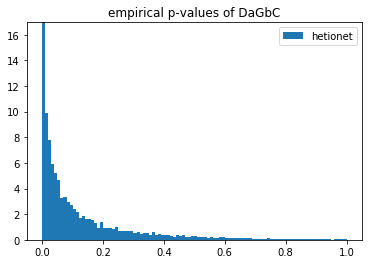

In [46]:
plt.title(f"empirical p-values of {metapath}")
heights, bins, _ = plt.hist(rows_df['p_value'], bins=bins, density=True, label='hetionet')
plt.legend()
plt.ylim((0, heights[0:-1].max()));